# From Classification (Easy) to Semantics (Hard)

**Author:** [Liam O'Driscoll](https://github.com/lodriscoll)<br>
**Date created:** 06/04/2023<br>
**Last modified:** 06/04/2023<br>


# Introduction

This exercise reviews image classification, implements semantic segmentation and object detection, and reviews three of the large scale datasets mentioned in lecture.

## Setup

We must first begin by importing the necessary packages. We will be using [Tensorflow](https://www.tensorflow.org/) and Keras to implement our models.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

import matplotlib.pyplot as plt

import numpy as np

2023-06-06 04:55:24.730255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 04:55:24.909318: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 04:55:24.913071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-06 04:55:24.913098: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Data

For the classification portion of this exercise we will be training and evaluating using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a subset of the CIFAR-100 dataset. The CIFAR-100 is a significant dataset in the field of computer vision and machine learning, consisting of 600,000 color images divided into 1000 fine-grained classes. It served as a benchmark in the early era of big data, providing a challenging and diverse dataset for image classification tasks. CIFAR-100 played a crucial role in pushing the boundaries of machine learning algorithms and architectures, particularly in the development of deep learning models like convolutional neural networks (CNNs). Its large-scale nature and diverse classes contributed to advancing the field of computer vision research and fostering innovation in the early days of big data in machine learning. Today we will be using CIFAR-10 as a benchmark to test our classification networks. Keras has already implemented a load_data() function for this operation so we will leverage this. 

In [2]:
# Load CIFAR-10 dataset
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()

# Print shape of the loaded data
print("Training data shape:", x_train_raw.shape)  # (50000, 32, 32, 3)
print("Training labels shape:", y_train_raw.shape)  # (50000, 1)
print("Test data shape:", x_test_raw.shape)  # (10000, 32, 32, 3)
print("Test labels shape:", y_test_raw.shape)  # (10000, 1)

# Convert labels to categorical format
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes)

# Normalize input data
x_train = x_train_raw.astype('float32') / 255.0
x_test = x_test_raw.astype('float32') / 255.0


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


## Visualization
Lets take a look at a few examples by sampling the training set randomly and displaying the image with its corresponding label. 

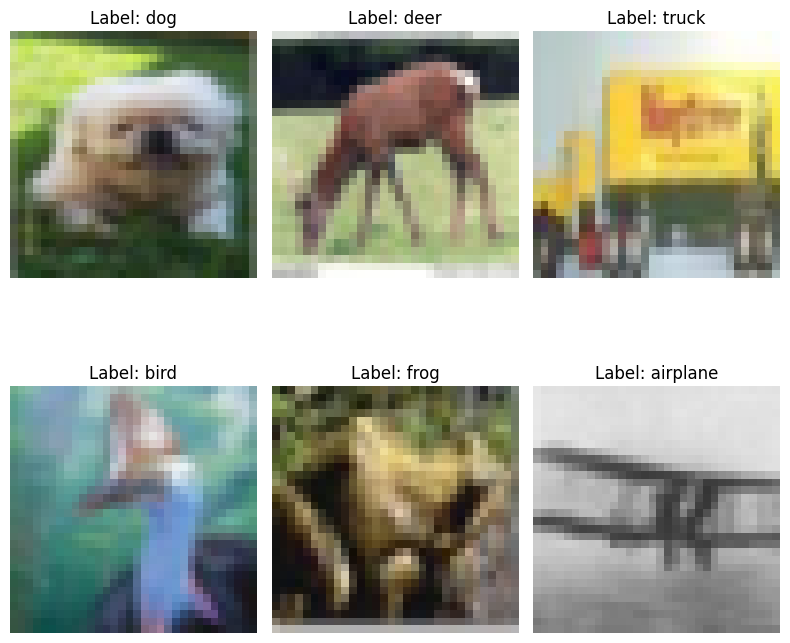

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(x, y, class_names, num_images=6):
    # Generate random indices to select sample images from the dataset
    indices = np.random.randint(0, len(x), num_images)
    
    # Create a subplot grid based on the number of images
    num_rows = (num_images + 2) // 3
    fig, axes = plt.subplots(num_rows, 3, figsize=(8, 4 * num_rows))
    
    # Iterate over the images and plot them with their labels
    for i, index in enumerate(indices):
        row = i // 3
        col = i % 3
        
        image = x[index]
        label = y[index]
        class_name = class_names[np.argmax(label)]
        
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Label: {class_name}")
    
    # Adjust the spacing and display the plot
    plt.tight_layout()
    plt.show()
    
# Define the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot 5 sample images with their labels
plot_sample_images(x_train, y_train, class_names, num_images=6)

# Classification

We can now build our first classification network. Lets start with a fully connected neural network (also called a Multilayer Perceptron Network or  MLP).

## Fully Connected Neural Network (MLP)

This model has 4 hidden layers, is optimized with adam, and is trained for 10 epochs with a batchsize of 32. 

In [4]:
def build_mlp_model():
    # Build model
    model = Sequential()

    # Input shape matches the dimensions of images
    model.add(Input(shape=(32, 32, 3)))

    # Flatten to pass into dense layer
    model.add(Flatten())

    # Four hidden layers
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))

    # Output layer with 10 units corresponding to classes with softmax activation
    model.add(Dense(units=10, activation='softmax'))

    # Use categorical_crossentropy because the labels were one-hot encoded
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def train_mlp_model(model, X_train, y_train, ):
    # train model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32)
    
    #return history
    return history

def evaluate_mlp_model(model, X_test, y_test):
    # Evaluate the model
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}")
    print(f"Test accuracy: {accuracy:.4f}")

    
mlp_model = build_mlp_model()

history = train_mlp_model(mlp_model, x_train, y_train)

evaluate_mlp_model(mlp_model, x_test, y_test)


2023-06-06 04:18:28.489777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-06 04:18:28.489828: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-06 04:18:28.489858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-1-vm): /proc/driver/nvidia/version does not exist
2023-06-06 04:18:28.490301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 1.8946 - accuracy: 0.3076
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7151 - accuracy: 0.3831
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6410 - accuracy: 0.4078
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5852 - accuracy: 0.4299
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5438 - accuracy: 0.4462
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5121 - accuracy: 0.4564
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4902 - accuracy: 0.4666
Epoch 8/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4654 - accuracy: 0.4765
Epoch 9/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4447 - accuracy: 0.4826
Epoch 10/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.427

### Discussion

As we can see, our current model is struggling to fit the training set. To improve its performance, we can consider implementing the following techniques:

- Adding more layers to the model, which can increase its capacity to learn complex patterns. [Regularization](https://keras.io/api/layers/regularizers/), such as L1 or L2 regularization, can also be applied to prevent overfitting.

- Utilizing [batch normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/), which normalizes the activations of the previous layer, helping the model to converge faster and generalize better.

- Introducing [dropout layers](https://keras.io/api/layers/regularization_layers/dropout/) to randomly deactivate some neurons during training, which reduces overfitting and encourages the network to learn more robust features.

- Optimizing hyperparameters using techniques like [random grid search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/), which systematically explores the hyperparameter space to find the best combination.

### Limitations
Even if we took the time to implemented these techniques and fine tune the hyperparameters, fully connected networks suffer from two significant and related problems:

1) **Large number of parameters:** In our case, each pixel in the 32x32 image requires a separate input neuron, resulting in an explosion of parameters as the network deepens. This leads to computational inefficiency and can cause overfitting.

2) **Location Depended Pattern Recognition:** Fully connected networks can only detect patterns in the exact same x, y location where they were learned. This limitation hampers their ability to generalize and recognize patterns in different spatial locations.

To address these issues, we can turn to [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network). CNNs are specifically designed to handle spatially structured data like images and provide simultaneous solutions to the problems mentioned above.

### Convolutional Neural Network

To address the limitations of the fully connected network, we can introduce an **inductive bias**, also known as human priors, to improve the model's capabilities. We want to improved efficiency and global pattern recognition. To do so we introduce the convolution operation. This new operation involves sliding windows with their own set of weights across the image. This operation offers two main advantages:

1) **Parameter sharing:** The same set of weights is used across different locations in the input, resulting in improved efficiency. This reduces the number of parameters required to learn from the data.

2) **Translation invariance:** The convolution operation allows patterns to be recognized regardless of their position in the image. This enhances the model's ability to generalize and detect features at different locations.

To leverage the benefits of CNNs, we construct a new model with 3 convolution and max-pooling blocks. This architecture allows us to increase the channel depth while compressing spatial information, enabling the network to capture relevant features and hierarchies present in the data more effectively.


In [5]:
def build_cnn_model():
    
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(10, activation='softmax'))
              
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

def train_cnn_model(model, x_train, y_train):
    # fit the model
    history = model.fit(x_train, y_train, batch_size=32, epochs=10,)
    # return history
    return history

def evaluate_cnn_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}")
    print(f"Test accuracy: {accuracy:.4f}")
    
    
cnn_model = build_cnn_model()

history = train_cnn_model(cnn_model, x_train, y_train)

evaluate_cnn_model(cnn_model, x_test, y_test)


Epoch 1/10
250/250 [==============================] - 185s 735ms/step - loss: 1.6385 - accuracy: 0.3932
Epoch 2/10
250/250 [==============================] - 184s 736ms/step - loss: 1.0567 - accuracy: 0.6217
Epoch 3/10
250/250 [==============================] - 185s 738ms/step - loss: 0.8055 - accuracy: 0.7178
Epoch 4/10
250/250 [==============================] - 184s 736ms/step - loss: 0.6481 - accuracy: 0.7717
Epoch 5/10
250/250 [==============================] - 184s 738ms/step - loss: 0.5119 - accuracy: 0.8220
Epoch 6/10
250/250 [==============================] - 185s 737ms/step - loss: 0.4088 - accuracy: 0.8558
Epoch 7/10
250/250 [==============================] - 184s 736ms/step - loss: 0.3031 - accuracy: 0.8920
Epoch 8/10
 26/250 [==>...........................] - ETA: 2:42 - loss: 0.2009 - accuracy: 0.9304

KeyboardInterrupt: 

### Discussion

The comparison between the accuracies of the CNN and fully connected network clearly demonstrates the superiority of CNN in performance. As discussed earlier, the convolution operation provides more robust generalization for image data.

### Limitations

Although the vanilla convolutional neural network (CNN) is a significant improvement over the fully connected network, it still has inherent limitations. In fact, these limitations are byproducts of our inductive bias. One of these limitations is the lack of access to the context of the original image in later layers. This issue arises due to the simultaneous spatial compression and expansion of channel depth. To overcome this limitation, a concept called residual layers is introduced.

**Residual layers** act as skip connections between a layer and its previous layer, allowing the propagation of context throughout the network when it is optimal to do so. This concept plays a vital role in the design of the ResNet50 classification network, which addresses the limitation of context loss in CNNs.

## Go Larger and Deeper - ResNet50

ResNet50 is a deep convolutional neural network architecture that significantly improves the performance and training of CNNs. It introduces the concept of residual learning, where residual layers are added to the network to mitigate the issue of context loss in deeper layers. The ResNet50 architecture consists of 50 layers, including convolutional layers, pooling layers, and fully connected layers. It has achieved state-of-the-art results on various image classification tasks.

The ResNet50 model was originally trained on the [ImageNet](https://www.image-net.org/) dataset, the second large scale dataset we will use that was instrumental in the era of big data. ImageNet is a large-scale dataset containing millions of labeled images from thousands of categories. ImageNet serves as a benchmark dataset for training and evaluating deep learning models for image classification. The dataset spans a wide range of visual concepts, including objects, animals, and scenes.

By pre-training ResNet50 on ImageNet, the model learns to extract meaningful and discriminative features from images. These learned features can then be fine-tuned or transferred to other datasets, including those with specific classes like the CIFAR-10 dataset.

By incorporating residual layers and leveraging their skip connections, ResNet50 allows the network to learn more effectively and capture both low-level and high-level features in an image. This architecture has been widely adopted and serves as a powerful tool for various computer vision tasks.

For further details and implementation specifics, please refer to the [ResNet50 paper](https://arxiv.org/abs/1512.03385). We will adapt this architecture to our specific needs, in this case classifying the CIFAR-10 dataset. We will use a transfer learning approach -- the following code should look extremely familiar from CSE144.


In [ ]:
def build_transfer_model():
    
    res_model = ResNet50(include_top=False, weights="imagenet", input_shape=(32, 32, 3))

    # for layer in res_model.layers:
    #    layer.trainable = False

    model = Sequential()
    model.add(res_model)
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def train_transfer_model(transfer_model, x_train, y_train):
    # preprocess data as specified in the keras resnet docs
    x_train_proc = preprocess_input(x_train)
    
    # Train the transfer learning model
    history = transfer_model.fit(x_train_proc, y_train, epochs=10, batch_size=32) 
    
    return history

def evaluate_transfer_model(transfer_model, x_test, y_test):
    # preprocess and normalize data
    x_test_proc = preprocess_input(x_test)
    
    # Evaluate the transfer learning model
    loss, accuracy = transfer_model.evaluate(x_test_proc, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}")
    print(f"Test accuracy: {accuracy:.4f}")
    
    
transfer_model = build_transfer_model()

history = train_transfer_model(transfer_model, x_train, y_train)

evaluate_transfer_model(transfer_model, x_test, y_test)


### Discussion

As we can see, ResNet offers another significant improvement over the traditional CNN model. The addition of skip connections, also known as residual connections, plays a crucial role in enhancing the model's performance. These skip connections allow for the direct flow of information from earlier layers to later layers, mitigating the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) and enabling the network to learn more effectively. By preserving and propagating gradients, the skip connections help to alleviate the challenges of training very deep networks. Additionally, the skip connections introduce shortcut paths that bypass a few layers, enabling the model to capture both low-level and high-level features more efficiently. This improved information flow and feature preservation contribute to the enhanced performance of ResNet on various tasks, including image classification.

### Limitations

One of the main limitations of ResNet is its computational cost. The deep structure of ResNet, especially in variants like ResNet50, requires significant computational resources and training time. Training such models on large-scale datasets or with limited computing power can be challenging. Additionally, the large number of parameters in ResNet increases the risk of overfitting, especially when the training dataset is small or lacks diversity. Regularization techniques such as dropout and weight decay can help mitigate overfitting to some extent.

While ResNet has shown impressive performance, it has a limitation in terms of contextual information utilization. The skip connections in ResNet only propagate information from the previous layer to the next layer. As a result, later layers may not have direct access to the entire context of the original image, which can limit their ability to effectively utilize global information. This limitation can impact the model's performance, particularly in tasks that require capturing long-range dependencies or contextual understanding.

## DenseNet

DenseNet is an architecture that addresses the limitation of contextual information utilization in ResNet by introducing dense connections. In DenseNet, each layer is connected to all previous layers, allowing for direct information flow from all preceding layers. This design enables dense connections to propagate richer and more comprehensive information throughout the network. By incorporating dense connections, DenseNet facilitates better information flow, gradient propagation, and feature reuse across different layers.

The dense connections in DenseNet contribute to improved model performance and better utilization of contextual information. This architecture encourages feature reuse and enables the network to capture fine-grained details and long-range dependencies more effectively. DenseNet has demonstrated state-of-the-art performance in various computer vision tasks, including image classification, object detection, and semantic segmentation.

The dense connectivity pattern in DenseNet results in increased memory consumption and computational requirements compared to traditional architectures like ResNet. However, it also offers advantages such as reducing the number of parameters and improving model compactness. DenseNet has become a significant advancement in deep learning architectures and has attracted considerable attention in the research community.

For more details on the DenseNet architecture, you can refer to the original [DenseNet paper](https://arxiv.org/abs/1608.06993). The implementation of DenseNet is beyond the scope of this exercise so we will be moving on from classification to semantics. 

# Semantics

After comprehensively reviewing classification we are now equipped with the tools to move onto a more challenging beast: semantic segmentation. As we learned, Image classification is the task of assigning a single label or class to an entire image. The goal is to determine what is present in the image and categorize it into one of several predefined classes. The output of image classification is a single class label or a probability distribution over class labels.

On the other hand, semantic segmentation is the task of pixel-level labeling, where the objective is to assign a class label to each individual pixel in an image. The goal is to classify and differentiate the various objects or regions within an image. Semantic segmentation provides a detailed understanding of the scene by segmenting the image into different meaningful regions. For example, in an image containing a dog and a cat, semantic segmentation would aim to assign a specific label to each pixel belonging to the dog and the cat separately. The output of semantic segmentation is a pixel-wise classification map, where each pixel is assigned a class label. 

## Data

To achieve this let's take a look at the third, and final large scale dataset: [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/). This dataset is widely used in semantic segmentation and object detection, two tasks we will tackle next. First lets download the data using the tensorflow_datasets library and the visualize the results


In [35]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('voc/2012', split='train+test', with_info=True)

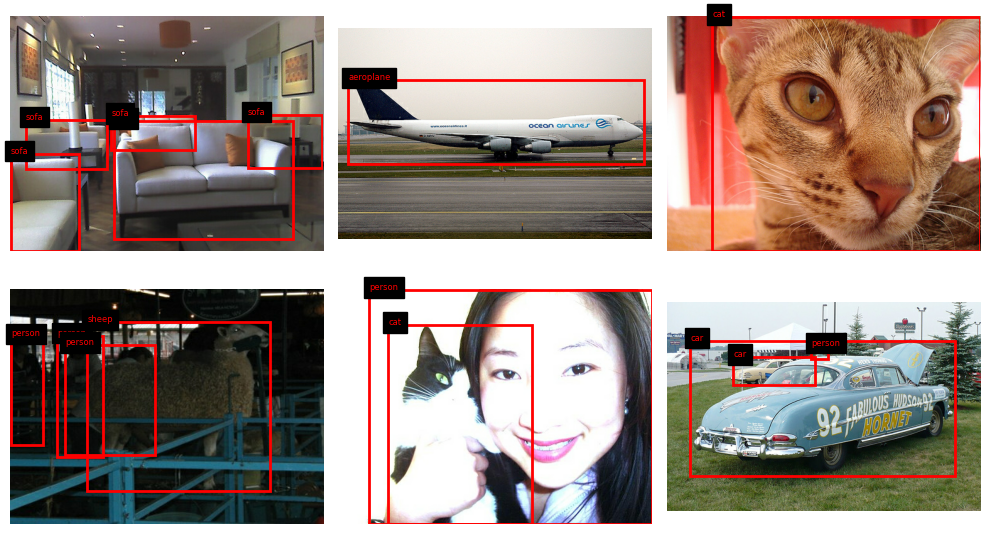

In [44]:
import matplotlib.pyplot as plt
import math

# VOC 2012 label list
voc_labels = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def get_images_with_bounding_boxes(dataset):
    images_with_bbox = []
    for data in dataset:
        if len(data['objects']['bbox']) > 0:
            images_with_bbox.append(data)
    return images_with_bbox

def visualize_random_samples(dataset, num_samples=6):
    images_with_bbox = get_images_with_bounding_boxes(dataset)
    samples = random.sample(images_with_bbox, num_samples)
    
    num_rows = num_samples // 3
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 6))
    axes = axes.flatten()
    
    for i, data in enumerate(samples):
        image = data['image']
        bounding_boxes = data['objects']['bbox']
        class_labels = data['objects']['label']
        
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        
        for bbox, label in zip(bounding_boxes, class_labels):
            ymin, xmin, ymax, xmax = bbox
            xmin *= image.shape[1]
            xmax *= image.shape[1]
            ymin *= image.shape[0]
            ymax *= image.shape[0]
            width = xmax - xmin
            height = ymax - ymin
            
            rect = plt.Rectangle((xmin, ymin), width, height, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            
            label_index = label.numpy()
            label_text = voc_labels[label_index]
            ax.text(xmin, ymin, label_text, color='red', fontsize=6, backgroundcolor='black')
    
    plt.tight_layout()
    plt.show()

visualize_random_samples(dataset)

In [45]:
segmentation_dataset = tfds.load('voc/2012', split='train', shuffle_files=True, download=True, as_supervised=True)

ValueError: as_supervised=True but voc does not support a supervised structure.